### Preprocessing and Modeling: Sentiment Analysis For Customer Interactions In X (Formerly Twitter)

This notebook is structured to guide through the preprocessing and modeling stages of a sentiment analysis project. The primary objective is to categorize X (formerly Twitter) customer support interactions into distinct sentiment classes. This involves transforming cleaned tweet data for machine learning applications and performing sentiment analysis to extract meaningful business insights.

#### Preprocessing
- **Objective**: Ready the cleaned dataset for detailed sentiment analysis and feature extraction.
- **Key Steps**:
  - Application of advanced NLP techniques like lemmatization and removal of stopwords to refine the text data.
  - Execution of feature engineering to extract significant attributes from the data, including text length, frequency of product mentions, and sentiment scores.
  - Development of additional derived features such as part-of-speech tags and named entity recognition to enhance the dataset's richness.

#### Feature Extraction and Selection
- **Objective**: Extract and identify key features for the sentiment analysis model.
- **Methodology**:
  - Employment of TF-IDF vectorization to numerically represent text data, highlighting word significance within the dataset.
  - Incorporation of count-based features like noun and adjective counts, adding depth to the model's understanding.
  - Selection of a diversified set of text-based and derived features to form a comprehensive input for the model.

#### Model Building and Evaluation
- **Objective**: Develop and evaluate models for classifying tweets into sentiment categories.
- **Approach**:
  - Exploration of various machine learning models including Logistic Regression, Support Vector Machine, Random Forest, and Gradient Boosting Machines.
  - Assessment of model performance using metrics such as accuracy, precision, recall, and F1-score to gauge effectiveness.
  - Optimization of model parameters and feature selection to enhance accuracy and performance.

#### Sentiment Classification
- **Objective**: Precise classification of customer interactions into positive, negative, or neutral sentiments.
- **Details**:
  - Integration of trained models for predicting sentiment labels on new data.
  - Analysis of model predictions to gain insights into customer sentiment trends and brand performance.

#### Final Model Selection and Deployment Considerations
- **Objective**: Identify the most effective model and plan its deployment.
- **Strategy**:
  - Comparison of different models to select the most suitable one for sentiment classification.
  - Discussion of potential deployment methodologies, including options for real-time analysis and integration within customer support frameworks.

This notebook underscores the significance of meticulous data preparation, strategic feature engineering, and judicious model selection in sentiment analysis, aiming to showcase advanced data science proficiency and a pragmatic approach to addressing real-world problems.

In [1]:
import sys
sys.path.append('../scripts/')

In [2]:
# imports for processing
import logging
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import spacy
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

In [3]:
# imports for modeling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from joblib import load, dump
import pickle
from sklearn.preprocessing import LabelEncoder
import logging
import warnings
from utils import *
from sklearn.model_selection import train_test_split

In [4]:
# setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# set up spacy 
nlp = spacy.load('en_core_web_sm')

#### Loading Cleaned Data:

In [5]:
try: 
    file_path = '../data/interim/cleaned_data.csv'
    df = load_data(file_path=file_path)
    logging.info("Data loaded successfully")
except Exception as e:
    logging.error(f"Error while loading the dataset: {e}")

2023-12-20 20:54:48,857 - INFO - Starting execution of load_data
2023-12-20 20:54:49,482 - INFO - Data loading completed successfully
2023-12-20 20:54:49,485 - INFO - Data loaded successfully


In [6]:
df.head()

,tweet_id,author_id,created_at,text,response_tweet_id,in_response_to_tweet_id,cleaned_text,sentiment,message_length
0,2,115712,2017-10-31 22:11:45,@sprintcare and how do you propose we do that,NaN,1.0,and how do you propose we do that,0.0000,33
1,3,115712,2017-10-31 22:08:27,@sprintcare I have sent several private messag...,1,4.0,i have sent several private messages and no on...,-0.2960,70
2,5,115712,2017-10-31 21:49:35,@sprintcare I did.,4,6.0,i did,0.0000,5
3,8,115712,2017-10-31 21:45:10,@sprintcare is the worst customer service,"9,6,10",NaN,is the worst customer service,-0.6249,29
4,12,115713,2017-10-31 22:04:47,@sprintcare You gonna magically change your co...,"11,13,14",15.0,you gonna magically change your connectivity f...,0.0000,71


In [7]:
# df['cleaned_text'].apply(type).value_counts()

cleaned_text
<class 'str'>    100000
Name: count, dtype: int64

#### Preprocessing:

We will perform a series of steps to transform the data for modeling by doing this, we ensure the consistency on responses. We will also add some engineered features that will enhance the model for the response generation.

In [7]:
# converting cleaned_text values to str in case there are other datatypes
df['cleaned_text'] = df['cleaned_text'].astype(str)

# applying preprocessing
df['processed'] = df['cleaned_text'].apply(preprocess_text)
df['processed_text'] = df['processed'].apply(lambda x: x['processed_text'])
df['pos_tags'] = df['processed'].apply(lambda x: x['pos_tags'])
df['noun_count'] = df['pos_tags'].apply(lambda tags: tags.count('NOUN'))
df['adj_count'] = df['pos_tags'].apply(lambda tags: tags.count('ADJ'))
# text complexity
df['text_complexity'] = df['processed_text'].apply(lambda x: len(set(x.split())) / len(x.split()) if x.split() else 0)

In [8]:
# saving preprocessed data to csv
folder_path2 = '../data/'  # Adjust the path as needed
file_name2 = 'processed/processed_data.csv'
full_path2 = save_data(df, folder_path2, file_name2)

if full_path2:
    print(f"DataFrame saved at: {full_path2}")
else:
    print("Failed to save the DataFrame.")

2023-12-20 21:08:59,878 - INFO - DataFrame saved successfully to ../data/processed/processed_data.csv


DataFrame saved at: ../data/processed/processed_data.csv


In [9]:
# Apply NER
df['entities'] = df['text'].apply(extract_entities)
# count product mention
df['product_mentions'] = df['entities'].apply(lambda ents: sum('PRODUCT' in ent for ent in ents))
# text length in processed-lemmatized text
df['text_length'] = df['processed_text'].apply(len)
# brands count
df['brand_mentions'] = df['entities'].apply(lambda ents: sum('ORG' in ent for ent in ents))

In [10]:
# saving preprocessed data to csv
folder_path2 = '../data/'  # Adjust the path as needed
file_name2 = 'processed/processed_data.csv'
full_path2 = save_data(df, folder_path2, file_name2)

if full_path2:
    print(f"DataFrame saved at: {full_path2}")
else:
    print("Failed to save the DataFrame.")

2023-12-20 21:20:41,397 - INFO - DataFrame saved successfully to ../data/processed/processed_data.csv


DataFrame saved at: ../data/processed/processed_data.csv


In [4]:
try: 
    file_path = '../data/processed/processed_data.csv'
    df = load_data(file_path=file_path)
    logging.info("Data loaded successfully")
except Exception as e:
    logging.error(f"Error while loading the dataset: {e}")

2023-12-12 10:25:52,083 - INFO - Starting execution of load_data
2023-12-12 10:25:53,212 - INFO - Data loading completed successfully
2023-12-12 10:25:53,217 - INFO - Data loaded successfully


In [11]:
# creating dependent variable
def categorize_sentiment(score, pos_threshold=0.1, neg_threshold=-0.1):
    """
    Categorize sentiment score into classes with error handling and logging.
    Args:
    score (float): Sentiment score.
    pos_threshold (float): Threshold for positive sentiment.
    neg_threshold (float): Threshold for negative sentiment.
    Returns:
    str: Sentiment category ('Positive', 'Negative', 'Neutral').
    """
    try:
        if score > pos_threshold:
            sentiment = 'Positive'
        elif score < neg_threshold:
            sentiment = 'Negative'
        else:
            sentiment = 'Neutral'
        return sentiment
    except Exception as e:
        logging.error(f"Error in categorizing sentiment: {e}")
        return 'Neutral'

# applying the function to create a derived sentiment column
df['derived_sentiment'] = df['sentiment'].apply(categorize_sentiment)

In [12]:
# data validation check
df.head()

,tweet_id,author_id,created_at,text,response_tweet_id,in_response_to_tweet_id,cleaned_text,sentiment,message_length,processed,processed_text,pos_tags,noun_count,adj_count,text_complexity,entities,product_mentions,text_length,brand_mentions,derived_sentiment
0,2,115712,2017-10-31 22:11:45,@sprintcare and how do you propose we do that,NaN,1.0,and how do you propose we do that,0.0000,33,"{'processed_text': 'propose', 'pos_tags': ['CC...",propose,"[CCONJ, SCONJ, AUX, PRON, VERB, PRON, VERB, PRON]",0,0,1.0,[],0,7,0,Neutral
1,3,115712,2017-10-31 22:08:27,@sprintcare I have sent several private messag...,1,4.0,i have sent several private messages and no on...,-0.2960,70,{'processed_text': 'send private message respo...,send private message respond usual,"[PRON, AUX, VERB, ADJ, ADJ, NOUN, CCONJ, DET, ...",2,3,1.0,[],0,34,0,Negative
2,5,115712,2017-10-31 21:49:35,@sprintcare I did.,4,6.0,i did,0.0000,5,"{'processed_text': '', 'pos_tags': ['PRON', 'V...",,"[PRON, VERB]",0,0,0.0,[],0,0,0,Neutral
3,8,115712,2017-10-31 21:45:10,@sprintcare is the worst customer service,"9,6,10",NaN,is the worst customer service,-0.6249,29,"{'processed_text': 'bad customer service', 'po...",bad customer service,"[AUX, DET, ADJ, NOUN, NOUN]",2,1,1.0,[],0,20,0,Negative
4,12,115713,2017-10-31 22:04:47,@sprintcare You gonna magically change your co...,"11,13,14",15.0,you gonna magically change your connectivity f...,0.0000,71,{'processed_text': 'gon na magically change co...,gon na magically change connectivity family,"[PRON, VERB, PART, ADV, VERB, PRON, NOUN, ADP,...",2,1,1.0,[],0,43,0,Neutral


#### Feature Engineering:

We will be creating main features for modeling(TF-IDF features) with TfidfVectorizer. Then, we will add the engineered features created previously into a sparse matrix so that the structure can be input into the ML models that will be trained and evaluated for the task. In order to create the matrix we will employ hstack function from the module scipy.

In [13]:
df['processed_text'] = df['processed_text'].fillna('')

# TF-IDF Vectorization
try:
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])
# Combine TF-IDF with other features
    additional_features = df[['noun_count', 'product_mentions', 'text_length', 'brand_mentions', 'adj_count', 'text_complexity']].values
    X_combined = hstack([X_tfidf, additional_features])
except Exception as e: 
    logging.error(f"Error while performing TfidfVectorizer and/or combining features: {e}")
    raise

#### Splitting Data: Train & Test

We will proceed to split the data into train and test so that we hold onto a set of the data to evaluate the models later on and avoid data leakage and biased models. 

In [14]:
try: 
    y = df['derived_sentiment']
    
    X_train, X_test, y_train, y_test = split_data(X_combined, y, test_size=0.3)
    logging.info("Split data function applied successfully")
except Exception as e:
    logging.error(f"Error while splitting data: {e}")
    raise

2023-12-20 21:31:38,304 - INFO - Data successfully split into train and test sets.
2023-12-20 21:31:38,305 - INFO - Split data function applied successfully


#### Scaling features: 

Scaling is a crucial step before training a ML model to ensure the features are within the same mean and std. Below, we will extract the count-based features (features extracted previously and stacked horizontally with main feature: TF-IDF). Then, we will use MinMaxScaler to standardize them and finally stack them back with the main and already normalized TF-IDF features. 

In [15]:
from sklearn.preprocessing import MaxAbsScaler

# number of count-based features
num_count_features = 6

try: # Extract count-based features from the end of each row in X_train and X_test
    X_train_counts = X_train[:, -num_count_features:]
    X_test_counts = X_test[:, -num_count_features:]

    # Normalize these features
    scaler = MaxAbsScaler()
    X_train_counts_scaled = scaler.fit_transform(X_train_counts)
    X_test_counts_scaled = scaler.transform(X_test_counts)

    # Recombine with the TF-IDF features
    X_train_scaled = hstack([X_train[:, :-num_count_features], X_train_counts_scaled])
    X_test_scaled = hstack([X_test[:, :-num_count_features], X_test_counts_scaled])
    logging.info("Count-based features scaled successfully")
except Exception as e: 
    logging.error(f"Error while scaling count-based features: {e}")
    raise

2023-12-20 21:37:09,323 - INFO - Count-based features scaled successfully


In [16]:
# encoding y_train and y_test for XGBoost Modeling
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#### Saving Data: 

Below we will leverage the module joblib to save the train and test sets for future use. This step is to avoid repetitive processes and ensure scalability and seamlessly collaboration.

In [17]:
# Paths for saving the datasets
X_train_path = '../data/processed/X_train_scaled.joblib'
X_test_path = '../data/processed/X_test_scaled.joblib'
y_train_path = '../data/processed/y_train.joblib'
y_test_path = '../data/processed/y_test.joblib'
y_train_encoded_path = '../data/processed/y_train_encoded.joblib'
y_test_encoded_path = '../data/processed/y_test_encoded.joblib'

# Saving the datasets
try:
    dump(X_train_scaled, X_train_path)
    logging.info(f"X_train_scaled saved successfully at {X_train_path}")

    dump(X_test_scaled, X_test_path)
    logging.info(f"X_test_scaled saved successfully at {X_test_path}")

    dump(y_train, y_train_path)
    logging.info(f"y_train saved successfully at {y_train_path}")

    dump(y_test, y_test_path)
    logging.info(f"y_test saved successfully at {y_test_path}")

    dump(y_train_encoded, y_train_encoded_path)
    logging.info(f"y_train_encoded saved successfully at {y_train_encoded_path}")

    dump(y_test_encoded, y_test_encoded_path)
    logging.info(f"y_test_encoded saved successfully at {y_test_encoded_path}")
except Exception as e:
    logging.error(f"Error while saving datasets: {e}")

2023-12-20 21:42:17,914 - INFO - X_train_scaled saved successfully at ../data/processed/X_train_scaled.joblib
2023-12-20 21:42:17,917 - INFO - X_test_scaled saved successfully at ../data/processed/X_test_scaled.joblib
2023-12-20 21:42:17,922 - INFO - y_train saved successfully at ../data/processed/y_train.joblib
2023-12-20 21:42:17,927 - INFO - y_test saved successfully at ../data/processed/y_test.joblib
2023-12-20 21:42:17,928 - INFO - y_train_encoded saved successfully at ../data/processed/y_train_encoded.joblib
2023-12-20 21:42:17,930 - INFO - y_test_encoded saved successfully at ../data/processed/y_test_encoded.joblib


### Model Building, Training, and Testing: Sentiment Analysis Project

This section of the notebook is dedicated to building, training, and testing various machine learning models for sentiment analysis. Our goal is to classify Twitter customer support interactions into sentiment categories: positive, negative, or neutral. We have chosen four models for this task, each with distinct characteristics and strengths:

#### 1. Logistic Regression
- **Approach**: We will tune hyperparameters like regularization strength (C) and iteration count, striving for a balance between model simplicity and predictive performance.

#### 2. Support Vector Machine (SVM)
- **Approach**: We'll explore both linear and non-linear kernels, aiming to capture complex patterns in the data while maintaining model efficiency.

#### 3. Random Forest Classifier
- **Approach**: We will focus on tuning tree-specific parameters like the number of trees and tree depth to optimize performance and prevent overfitting.

#### 4. Gradient Boosting Machines (XGBoost)
- **Approach**: We'll implement careful tuning of learning rate, number of estimators, and tree complexity, aiming to enhance the model's ability to sequentially learn from misclassified data points.


### Testing and Evaluation:
For each model, we'll perform the following:
- **Cross-Validation**: To ensure robustness and generalizability, we'll use cross-validation techniques during hyperparameter tuning.
- **Model Evaluation**: Post-training, we'll assess each model on the test dataset using metrics such as accuracy, precision, recall, and F1-score, providing a holistic view of each model's performance.

The selection of these models demonstrates a strategic approach to tackling a real-world sentiment analysis task, showcasing a solid grasp of data science principles and the ability to apply different machine learning techniques effectively.

In [5]:
# loading the data
# Paths where the datasets were saved
X_train_path = '../data/processed/X_train_scaled.joblib'
X_test_path = '../data/processed/X_test_scaled.joblib'
y_train_path = '../data/processed/y_train.joblib'
y_test_path = '../data/processed/y_test.joblib'
y_train_encoded_path = '../data/processed/y_train_encoded.joblib'
y_test_encoded_path = '../data/processed/y_test_encoded.joblib'

# Loading the datasets
try:
    X_train_scaled = load(X_train_path)
    logging.info("X_train_scaled loaded successfully.")

    X_test_scaled = load(X_test_path)
    logging.info("X_test_scaled loaded successfully.")

    y_train = load(y_train_path)
    logging.info("y_train loaded successfully.")

    y_test = load(y_test_path)
    logging.info("y_test loaded successfully.")

    y_train_encoded = load(y_train_encoded_path)
    logging.info("y_train_encoded loaded successfully.")

    y_test_encoded = load(y_test_encoded_path)
    logging.info("y_test_encoded loaded successfully.")
except Exception as e:
    logging.error(f"Error while loading datasets: {e}")

2023-12-21 09:41:32,545 - INFO - X_train_scaled loaded successfully.
2023-12-21 09:41:32,549 - INFO - X_test_scaled loaded successfully.
2023-12-21 09:41:32,557 - INFO - y_train loaded successfully.
2023-12-21 09:41:32,561 - INFO - y_test loaded successfully.
2023-12-21 09:41:32,565 - INFO - y_train_encoded loaded successfully.
2023-12-21 09:41:32,569 - INFO - y_test_encoded loaded successfully.


In [6]:
# Initializing an empty DataFrame to store all model scores
all_model_scores = pd.DataFrame(columns=['Model', 'F1 Score', 'Accuracy', 'Recall', 'Precision'])

##### Logistic Regression:

In [7]:
logreg_model = LogisticRegression(max_iter=1000)

# Evaluate the model
logreg_scores = evaluate_with_cv(logreg_model, X_train_scaled, y_train, "Logistic Regression")

# Append to the master DataFrame
try:
    all_model_scores = pd.concat([all_model_scores, pd.DataFrame([logreg_scores])], ignore_index=True)
    logging.info("Model scores appended successfully.")
except Exception as e:
    logging.error(f"Error appending model scores: {e}")

2023-12-21 09:43:58,983 - INFO - Model scores appended successfully.


##### Support Vector Classifier (SVM)

In [9]:
# stratified sampling to optimize training times
sample_size = 0.5

# Perform stratified sampling
X_train_sampled, _, y_train_sampled, _ = train_test_split(
    X_train_scaled, y_train, test_size=1 - sample_size, stratify=y_train, random_state=42
)

# initializing SVM - classifier model
svc_model = SVC(kernel='linear', cache_size=1000, tol=0.01)

# Evaluate the model
svc_scores = evaluate_with_cv(svc_model, X_train_sampled, y_train_sampled, "Support Vector Classifier (SVM)")


2023-12-21 12:50:17,832 - ERROR - Error appending model scores: cannot concatenate object of type '<class 'dict'>'; only Series and DataFrame objs are valid


In [10]:
# Append to the master DataFrame
try:
    all_model_scores = pd.concat([all_model_scores, pd.DataFrame([svc_scores])], ignore_index=True)
    logging.info("Model scores appended successfully.")
except Exception as e:
    logging.error(f"Error appending model scores: {e}")

2023-12-21 12:54:04,342 - INFO - Model scores appended successfully.


#### Random Forest Classifier

In [11]:
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Evaluate the model
rf_scores = evaluate_with_cv(rf_model, X_train_sampled, y_train_sampled, "Random Forest Classifier")

# Append to the master DataFrame
try:
    all_model_scores = pd.concat([all_model_scores, pd.DataFrame([rf_scores])], ignore_index=True)
    logging.info("Model scores appended successfully.")
except Exception as e:
    logging.error(f"Error appending model scores: {e}")

2023-12-21 13:28:49,297 - INFO - Model scores appended successfully.


#### XGBoost Classifier

In [12]:
# Train the XGBoost model with encoded labels
xgb_model = XGBClassifier(eval_metric='mlogloss')

# Evaluate the model
try:
    xgb_scores = evaluate_with_cv(xgb_model, X_train_scaled, y_train_encoded,  "XGBoost Classifier")
    all_model_scores = pd.concat([all_model_scores, pd.DataFrame([xgb_scores])], ignore_index=True)
    logging.info("XGBoost Classifier scores appended successfully.")
except Exception as e:
    logging.error(f"Error evaluating XGBoost Classifier: {e}")

2023-12-21 13:59:35,457 - INFO - XGBoost Classifier scores appended successfully.


In [15]:
try:
    all_model_scores = all_model_scores.drop(columns=["F1 Score", "Accuracy", "Recall", "Precision"], axis=1)

    all_model_scores
    logging.info("Columns dropped successfuly. Results DataFrame is completed")
except Exception as e:
    logging.error(f"Error while dropping columns: {e}")
    raise

2023-12-21 17:01:26,105 - INFO - Columns dropped successfuly. Results DataFrame is completed


In [16]:
all_model_scores

,Model,train_accuracy,train_precision_macro,train_recall_macro,train_f1_macro,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,Logistic Regression,0.775846,0.777486,0.771656,0.771761,0.765671,0.766945,0.761292,0.761228
1,Support Vector Classifier (SVM),0.778529,0.781786,0.774570,0.774476,0.763743,0.765967,0.759453,0.758924
2,Random Forest Classifier,0.992486,0.992679,0.992413,0.992508,0.719486,0.718009,0.715926,0.715362
3,XGBoost Classifier,0.788732,0.795321,0.784709,0.785260,0.755800,0.759700,0.751367,0.750897


In [17]:
try:
    save_data(df=all_model_scores, folder_path="../models/", file_name="default_metrics.csv")
    logging.info("Function applied successfully")
except Exception as e:
    logging.error("Error while applying function: {e}")
    raise

2023-12-21 17:08:10,614 - INFO - DataFrame saved successfully to ../models/default_metrics.csv
2023-12-21 17:08:10,615 - INFO - Function applied successfully


#### Hyperparameter Tunning:

Next, we will tune the models, evaluate them and select the best performing model in the unseen test set. The process will use RandomizedSearchCV as a 

In [18]:
# Initializing an empty DataFrame to store all tunned model scores 
all_model_scores2 = pd.DataFrame(columns=['Model', 'F1 Score', 'Accuracy', 'Recall', 'Precision'])

#### Tunning Logistic Regression Model

In [22]:
from scipy.stats import loguniform
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

# Adjusted Hyperparameter Distributions
param_dist_logreg = {
    'C': loguniform(1e-2, 1e2),  # Regularization strength
    # Chosen solvers that are compatible with 'l2' penalty
    'solver': ['newton-cg', 'lbfgs', 'sag'],  
    'penalty': ['l2']  # Only 'l2' penalty is included
}

logreg = LogisticRegression(max_iter=1000)

random_search_logreg = RandomizedSearchCV(
    logreg,
    param_distributions=param_dist_logreg,
    n_iter=100,
    cv=5,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
    refit='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Perform hyperparameter tuning
try:
    random_search_logreg.fit(X_train_sampled, y_train_sampled)
    best_logreg = random_search_logreg.best_estimator_
    logging.info("Hyperparameter tunning applied successfully")
except Exception as e:
    logging.error(f"Error while performing hyperparameter tunning: {e}")
    raise

Fitting 5 folds for each of 100 candidates, totalling 500 fits


2023-12-22 17:07:37,614 - INFO - Hyperparameter tunning applied successfully


##### Serializing Tuned LogReg 

In [23]:
random_search_logreg_path = '../models/random_search_logreg.joblib'
best_logreg_path = "../models/best_logreg.joblib"

try:
    dump(random_search_logreg, random_search_logreg_path)
    dump(best_logreg, best_logreg_path)
    logging.info(f"Models saved successfully at {random_search_logreg_path} and {best_logreg_path}")
except Exception as e:
    logging.error(f"Error saving the models: {e}")

2023-12-22 21:56:35,235 - INFO - Models saved successfully at ../models/random_search_logreg.joblib and ../models/best_logreg.joblib


#### Metrics for LogReg to DataFrame

In [24]:
try:
    logreg_results = evaluate_model(best_logreg, X_train_scaled, y_train, X_test_scaled, y_test)
    # Adding logreg scores to a df
    all_model_scores2 = pd.concat([all_model_scores2, pd.DataFrame([logreg_results])], ignore_index=True)
    logging.info("Best Logistic Regression model evaluated successfully and added to DataFrame")
except Exception as e:
    logging.error(f"Error while evaluating the model: {e}")
    raise

2023-12-22 22:05:37,431 - INFO - Best Logistic Regression model evaluated successfully and added to DataFrame


#### Tunning Random Forest Classifier Model

In [27]:
from scipy.stats import randint

# Hyperparameter distributions
param_dist_rf = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2']}

# Random Forest model
rf = RandomForestClassifier()

# RandomizedSearchCV setup
random_search_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist_rf,
    n_iter=150,
    cv=5,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro'
    },
    refit='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Perform hyperparameter tuning
try:
    random_search_rf.fit(X_train_sampled, y_train_sampled)
    best_rf = random_search_rf.best_estimator_
    logging.info("Hyperparameter tuning for Random Forest completed successfully.")
except Exception as e:
    logging.error(f"Error during hyperparameter tuning for Random Forest: {e}")

Fitting 5 folds for each of 150 candidates, totalling 750 fits


/Users/camilods16/opt/anaconda3/envs/nlp-c/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-23 15:42:29,271 - INFO - Hyperparameter tuning for Random Forest completed successfully.


##### Serializing Tuned Random Forest

In [28]:
# path to model
random_search_rf_path = '../models/random_search_rf.joblib'
best_rf_path = "../models/best_rf.joblib"

try:
    dump(random_search_rf, random_search_rf_path)
    dump(best_rf, best_rf_path)
    logging.info(f"Models saved successfully at {random_search_rf_path} and {best_rf_path}")
except Exception as e:
    logging.error(f"Error saving the models: {e}")

2023-12-23 16:57:45,664 - INFO - Models saved successfully at ../models/random_search_rf.joblib and ../models/best_rf.joblib


In [29]:
try:
    rf_results = evaluate_model(best_rf, X_train_scaled, y_train, X_test_scaled, y_test)
    # Adding random forest scores to a df
    all_model_scores2 = pd.concat([all_model_scores2, pd.DataFrame([rf_results])], ignore_index=True)
    logging.info("Best Random Forest model evaluated successfully and added to DataFrame")
except Exception as e:
    logging.error(f"Error while evaluating the model: {e}")
    raise

2023-12-23 17:29:10,400 - INFO - Best Random Forest model evaluated successfully and added to DataFrame


#### Tunning XGBoost Classifier Model

In [33]:
# encoding sampled y_train for XGBoost 
label_encoder2 = LabelEncoder()
y_train_sampled_encoded = label_encoder2.fit_transform(y_train_sampled)

In [34]:
from scipy.stats import uniform, randint

# Expanded hyperparameter distributions
param_dist_xgb = {
    'n_estimators': randint(100, 300),  
    'learning_rate': uniform(0.01, 0.3), 
    'max_depth': randint(3, 15),         
    'subsample': uniform(0.7, 0.3),      
    'colsample_bytree': uniform(0.7, 0.3), 
    'gamma': uniform(0, 5)               
}

# XGBoost model
xgb = XGBClassifier(eval_metric='mlogloss')

# RandomizedSearchCV setup with expanded hyperparameters
random_search_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist_xgb,
    n_iter=100,  
    cv=5,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro'
    },
    refit='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# hyperparameter tuning
try:
    random_search_xgb.fit(X_train_sampled, y_train_sampled_encoded)
    best_xgb = random_search_xgb.best_estimator_
    logging.info("Hyperparameter tuning for XGBoost completed successfully.")
except Exception as e:
    logging.error(f"Error during hyperparameter tuning for XGBoost: {e}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


2023-12-24 16:55:03,661 - INFO - Hyperparameter tuning for XGBoost completed successfully.


##### Serializing Tuned XGBoost Model 

In [35]:
# path to model
random_search_xgb_path = '../models/random_search_xgb.joblib'
best_xgb_path = "../models/best_xgb.joblib"

try:
    dump(random_search_xgb, random_search_xgb_path)
    dump(best_xgb, best_xgb_path)
    logging.info(f"Models saved successfully at {random_search_xgb_path} and {best_xgb_path}")
except Exception as e:
    logging.error(f"Error saving the models: {e}")

2023-12-24 17:00:23,829 - INFO - Models saved successfully at ../models/random_search_xgb.joblib and ../models/best_xgb.joblib


In [36]:
try:
    xgb_results = evaluate_model(best_xgb, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded)
    # Adding xgboost scores to a df
    all_model_scores2 = pd.concat([all_model_scores2, pd.DataFrame([xgb_results])], ignore_index=True)
    logging.info("Best XGBoost model evaluated successfully and added to DataFrame")
except Exception as e:
    logging.error(f"Error while evaluating the model: {e}")
    raise

2023-12-24 17:03:01,245 - INFO - Best XGBoost model evaluated successfully and added to DataFrame


#### Models Metrics: Tuned vs Default Models

In [39]:
try:
    all_model_scores2 = all_model_scores2.drop(columns=['F1 Score', 'Accuracy', 'Recall', 'Precision'], axis=1)
    logging.info("First three rows dropped successfully")
except Exception as e:
    logging.error(f"Error while dropping rows: {e}")
    raise

# displaying dataframe
all_model_scores2

2023-12-24 17:05:43,642 - INFO - First three rows dropped successfully


,Model,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1
0,LogisticRegression,0.776557,0.766333,0.778608,0.767826,0.772274,0.762439,0.772403,0.762131
1,RandomForestClassifier,0.701171,0.677033,0.703363,0.678031,0.698324,0.673792,0.698474,0.673577
2,XGBClassifier,0.796443,0.768200,0.801739,0.771682,0.792134,0.763903,0.792824,0.763696


##### Saving Metrics of Models

In [47]:
try:
    save_data(df=all_model_scores2, folder_path="../models/", file_name="tuned_models_metrics.csv")
    logging.info("Function applied successfully")
except Exception as e:
    logging.error("Error while applying function: {e}")
    raise

2023-12-24 19:19:24,703 - INFO - DataFrame saved successfully to ../models/tuned_models_metrics.csv
2023-12-24 19:19:24,704 - INFO - Function applied successfully


#### Model Selection: XGBoost Classifier Tuned Model

After evaluating models with default and tuned hyperparameters, we can observe the Extreme Gradient Boosting Classifier(XGBoost) perform better than other models in all metrics. We chose F1 as the baseline metric for evaluation since it presents a balanced measure between Precision and Recall. 

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

#### Creating Feature Importance Plot

In [49]:
try: 
    file_path = '../data/processed/processed_data.csv'
    df = load_data(file_path=file_path)
    logging.info("Data loaded successfully")
except Exception as e:
    logging.error(f"Error while loading the dataset: {e}")

2023-12-29 09:05:48,748 - INFO - Starting execution of load_data
2023-12-29 09:05:50,224 - INFO - Data loading completed successfully
2023-12-29 09:05:50,229 - INFO - Data loaded successfully


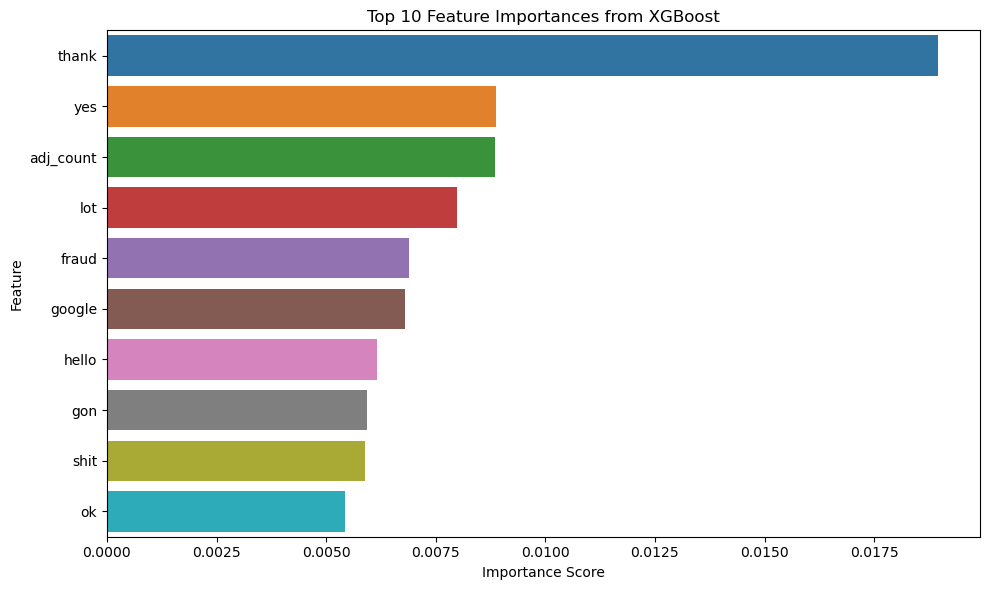

In [53]:
df['processed_text'] = df['processed_text'].fillna('')
# Initialize TfidfVectorizer and fit it on the full dataset
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_vectorizer.fit(df['processed_text'])

# Get feature names from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Additional feature names used during model training
additional_features_names = ['noun_count', 'product_mentions', 'text_length', 'brand_mentions', 'adj_count', 'text_complexity']

# Combine all feature names
all_feature_names = np.concatenate((feature_names, additional_features_names))

# Ensure you have the best XGBoost model loaded as best_xgb

# Extract feature importances
feature_importances = best_xgb.feature_importances_

# Adjust the length of feature_importances to match the length of all_feature_names
# This assumes that the first part of feature_importances corresponds to the TF-IDF features
# and the rest are the additional features.
feature_importances = np.concatenate((feature_importances[:len(feature_names)], feature_importances[-len(additional_features_names):]))

# Map feature names to their importances
feature_importance_dict = dict(zip(all_feature_names, feature_importances))

# Convert to a DataFrame for visualization
feature_importance_df = pd.DataFrame(list(feature_importance_dict.items()), columns=['Feature', 'Importance'])

# Sort the DataFrame by the absolute value of importances
feature_importance_df = feature_importance_df.reindex(feature_importance_df.Importance.abs().sort_values(ascending=False).index)

# Plot the top 10 feature importances
top_n = 10
top_features_df = feature_importance_df.head(top_n)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features_df['Importance'], y=top_features_df['Feature'])
plt.title(f'Top {top_n} Feature Importances from XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('xgb_feature_importances.png')
plt.show()